# Top 30 greenhouse gas emitters in Czechia


In [42]:
import enum
import os
import sys
from datetime import date

from IPython.display import Markdown
import matplotlib.pyplot as plt
import pandas as pd

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath(".."))

from data_analysis.allowances_utils import get_allowances_data
from data_analysis.emissions_pie_chart import get_total_emissions_value
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_geo
from data_analysis.illustrator_strings import czech_float


This notebook prepares data and charts for the infographic of top GHG emitters in Czechia.

The workflow is as follows:
1. Define parametrs and assign facility names and types to permit IDs
2. Load the ETS verified emissions dataset
3. Augment the ETS dataset with facility details and pivot for inspection
5. Compare with previous year
6. Generate helper bart chart and accompanying text


## Parameters and definitions


In [2]:
DATASET_PATH = "../data/EUA/verified_emissions_2023_en.xlsx"
FACILITY_DETAILS_PATH = "../data/EUA/top-emitters-cz.csv"

# Year we want to visualize.
YEAR = 2023
# Year we want to compare with (need not be the previous year).
# Typically, when updating, this is the year of the previous version
# of the infographic.
COMPARISON_YEAR = 2021
# Amount of emissions per one square.
SQUARE_VALUE_MT = 0.25

class SquareTypes(enum.Enum):
    HEAT_POWER = "HeatPower"
    STEEL = "IronSteel"
    REFINING = "Refining"
    LIME_CEMENT = "LimeCement"
    OTHER = "Other"

activites_map = {
    2: SquareTypes.REFINING.value,
    20: SquareTypes.HEAT_POWER.value,
    21: SquareTypes.REFINING.value,
    24: SquareTypes.STEEL.value,
    25: SquareTypes.STEEL.value,
    29: SquareTypes.LIME_CEMENT.value,
    30: SquareTypes.LIME_CEMENT.value,
}


## Load ETS dataset


In [3]:
def load_ets_data(year: int, country: str) -> pd.DataFrame:
    return (
        get_allowances_data(year, country, None, DATASET_PATH)
        .sort_values(by="value", ascending=False)
        .rename(
            columns={
                "MAIN_ACTIVITY_TYPE_CODE": "activity_code",
                "value": "MtCO2eq",
            }
        )
    )


In [4]:
allowances_df = load_ets_data(YEAR, "CZ")

allowances_df.head()


,MtCO2eq,IDENTIFIER_IN_REG,activity_code
PERMIT_IDENTIFIER,,,
CZ-0204-05,4.094255,"Elektrárna Počerady, a.s.",20
CZ-0209-05,3.570884,ČEZ - Elektrárna Tušimice 2,20
CZ-0207-05,3.025634,ČEZ - Elektrárna Prunéřov 2,20
CZ-0200-05,2.893905,Elektrárna Chvaletice a.s.,20
CZ-0201-05,2.823304,ČEZ - Elektrárna Ledvice,20


In [5]:
total_ets_emissions_mtco2eq = allowances_df.MtCO2eq.sum()

Markdown(
    f"Total emissions from Czechia in the ETS in {YEAR}: **{total_ets_emissions_mtco2eq:.1f} Mt** CO₂eq"
)


Total emissions from Czechia in the ETS in 2023: **46.7 Mt** CO₂eq

## Load facility details and pivot


In [21]:
def add_activities(ets: pd.DataFrame, facilities: pd.DataFrame) -> pd.DataFrame:
    # One facility may have multiple permits. Put one permit ID per row.
    facility_permits_map = facilities[["facility_id", "permit_ids"]].copy()
    facility_permits_map["permit_id"] = \
        facility_permits_map["permit_ids"].str.split("|")
    del facility_permits_map["permit_ids"]
    facility_permits_map = facility_permits_map.explode("permit_id")

    # Identify ETS data with facilities using the permit ID.
    facility_activity_df = (
        ets
        .merge(
            facility_permits_map[["facility_id", "permit_id"]],
            how="left",
            left_on="PERMIT_IDENTIFIER",
            right_on="permit_id"
        )
    )

    # Map activity codes to our predefined categories.
    facility_activity_df["activity"] = (
        facility_activity_df["activity_code"]
        .map(activites_map)
        .fillna(SquareTypes.OTHER.value)
    )

    return facility_activity_df

def add_facility_details(df: pd.DataFrame, facilities: pd.DataFrame) -> pd.DataFrame:
    # Calculate emissions by activity for each facility.
    known_facilities = (
        df[["facility_id", "activity", "MtCO2eq"]]
        .groupby(["facility_id", "activity"])
        .sum()
        .reset_index(level=1)
        # Augment with facility details – name and coordinates.
        .merge(
            facilities[["facility_id", "facility_name", "lat", "lon"]],
            how="left",
            left_index=True,
            right_on="facility_id"
        )
        .set_index(["facility_id", "facility_name"])
    )

    return known_facilities

facility_details = pd.read_csv(FACILITY_DETAILS_PATH)


In [22]:
facility_activity_df = add_activities(allowances_df, facility_details)
known_facilities = add_facility_details(facility_activity_df, facility_details)

# Pivot to columns (wide format) for inspection.
top_30_wide = known_facilities.pivot(columns="activity", values="MtCO2eq").fillna(0)
top_30_wide["Total"] = \
    top_30_wide[["HeatPower", "IronSteel", "LimeCement", "Refining"]].sum(axis=1)
top_30_wide = top_30_wide.sort_values(by="Total", ascending=False).head(30).round(3)
top_30_wide


,activity,HeatPower,IronSteel,LimeCement,Refining,Total
facility_id,facility_name,,,,,
1,Elektrárna Počerady,4.691,0.000,0.000,0.000,4.691
3,Třinecké železárny a Energetika Třinec,1.419,2.536,0.000,0.000,3.955
7,Elektrárna Tušimice,3.571,0.000,0.000,0.000,3.571
5,Rafinerie Litvínov,3.039,0.000,0.000,0.405,3.444
6,Elektrárna Prunéřov,3.026,0.000,0.000,0.000,3.026
8,Elektrárna Chvaletice,2.894,0.000,0.000,0.000,2.894
4,Elektrárna Ledvice,2.823,0.000,0.000,0.000,2.823
2,Liberty Ostrava a TAMEH Czech,2.392,0.041,0.000,0.000,2.433
9,Elektrárna Mělník,1.921,0.000,0.000,0.000,1.921


In [23]:
# A quick check that no large emitters were left behind.
facility_activity_df[facility_activity_df["facility_id"].isna()] \
    .sort_values(by="MtCO2eq", ascending=False).head()


,MtCO2eq,IDENTIFIER_IN_REG,activity_code,facility_id,permit_id,activity
40,0.237142,"Smartwings, a.s.",10,NaN,NaN,Other
42,0.206465,Synthesia - odštěpný závod SYNTHESIA,20,NaN,NaN,HeatPower
44,0.190399,Lovochemie - Uhelná kotelna,20,NaN,NaN,HeatPower
45,0.186415,AGC Flat Glass - závod Řetenice,31,NaN,NaN,Other
46,0.119417,Teplárny Brno - Provoz Červený Mlýn,20,NaN,NaN,HeatPower


Pivot back to long format for export and further processing.


In [24]:
top_30_long = known_facilities.loc[top_30_wide.index]
top_30_long.to_csv("../outputs/top-30-emitters-cz.csv")
print("Top 30 saved to top-30-emitters-cz.csv")


Top 30 saved to top-30-emitters-cz.csv


In [25]:
def square_count(series: pd.Series) -> int:
    return (series / SQUARE_VALUE_MT).round().astype(int)

def add_square_counts(df: pd.DataFrame) -> None:
    df = df.copy()

    df["sq_Total"] = square_count(df["Total"])

    for square_type in SquareTypes:
        if square_type.value not in df.columns:
            continue
        df[f"sq_{square_type.value}"] = square_count(df[square_type.value])

    return df


In [26]:
# Replace zeros in the table for legibility.
current_year_squares_df = add_square_counts(top_30_wide)

current_year_squares_df.replace(0, "-")


,activity,HeatPower,IronSteel,LimeCement,Refining,Total,sq_Total,sq_HeatPower,sq_IronSteel,sq_Refining,sq_LimeCement
facility_id,facility_name,,,,,,,,,,
1,Elektrárna Počerady,4.691,-,-,-,4.691,19,19,-,-,-
3,Třinecké železárny a Energetika Třinec,1.419,2.536,-,-,3.955,16,6,10,-,-
7,Elektrárna Tušimice,3.571,-,-,-,3.571,14,14,-,-,-
5,Rafinerie Litvínov,3.039,-,-,0.405,3.444,14,12,-,2,-
6,Elektrárna Prunéřov,3.026,-,-,-,3.026,12,12,-,-,-
8,Elektrárna Chvaletice,2.894,-,-,-,2.894,12,12,-,-,-
4,Elektrárna Ledvice,2.823,-,-,-,2.823,11,11,-,-,-
2,Liberty Ostrava a TAMEH Czech,2.392,0.041,-,-,2.433,10,10,-,-,-
9,Elektrárna Mělník,1.921,-,-,-,1.921,8,8,-,-,-


## Comparison with a previous year


In [29]:
comparison_allowances_df = add_facility_details(
    add_activities(
        load_ets_data(COMPARISON_YEAR, "CZ"),
        facility_details
    ),
    facility_details
)

comparison_df_wide = comparison_allowances_df.pivot(columns="activity", values="MtCO2eq").fillna(0)
comparison_df_wide["Total"] = \
    comparison_df_wide[["HeatPower", "IronSteel", "LimeCement", "Refining"]].sum(axis=1)
comparison_df_wide = comparison_df_wide.sort_values(by="Total", ascending=False).head(30).round(3)

comparison_year_squares_df = add_square_counts(comparison_df_wide)

comparison_year_squares_df.head()


,activity,HeatPower,IronSteel,LimeCement,Refining,Total,sq_Total,sq_HeatPower,sq_IronSteel,sq_Refining,sq_LimeCement
facility_id,facility_name,,,,,,,,,,
1,Elektrárna Počerady,5.390,0.000,0.0,0.000,5.390,22,22,0,0,0
2,Liberty Ostrava a TAMEH Czech,5.124,0.055,0.0,0.000,5.179,21,20,0,0,0
3,Třinecké železárny a Energetika Třinec,1.507,2.533,0.0,0.000,4.040,16,6,10,0,0
4,Elektrárna Ledvice,3.781,0.000,0.0,0.000,3.781,15,15,0,0,0
5,Rafinerie Litvínov,3.326,0.000,0.0,0.382,3.708,15,13,0,2,0


In [30]:
Markdown(f"Comparison of emissions in year **{YEAR} vs. {COMPARISON_YEAR}** by facility:")


Comparison of emissions in year **2023 vs. 2021** by facility:

In [31]:
diff_df = current_year_squares_df.subtract(comparison_year_squares_df, fill_value=0)

# Filter out items with no difference
zero_condition = diff_df["sq_Total"] == 0
for square_type in SquareTypes:
    if square_type not in diff_df.columns:
        continue
    zero_condition &= diff_df[f"sq_{square_type.value}"] == 0

# Replace zeros for legibility.
diff_df[~zero_condition].replace(0, "-")


,activity,HeatPower,IronSteel,LimeCement,Refining,Total,sq_Total,sq_HeatPower,sq_IronSteel,sq_Refining,sq_LimeCement
facility_id,facility_name,,,,,,,,,,
1,Elektrárna Počerady,-0.699,-,-,-,-0.699,-3.0,-3.0,-,-,-
2,Liberty Ostrava a TAMEH Czech,-2.732,-0.014,-,-,-2.746,-11.0,-10.0,-,-,-
4,Elektrárna Ledvice,-0.958,-,-,-,-0.958,-4.0,-4.0,-,-,-
5,Rafinerie Litvínov,-0.287,-,-,0.023,-0.264,-1.0,-1.0,-,-,-
6,Elektrárna Prunéřov,-0.469,-,-,-,-0.469,-2.0,-2.0,-,-,-
8,Elektrárna Chvaletice,-0.504,-,-,-,-0.504,-2.0,-2.0,-,-,-
9,Elektrárna Mělník,-0.469,-,-,-,-0.469,-2.0,-2.0,-,-,-
10,Teplárna Vřesová,-0.994,-,-,-,-0.994,-4.0,-4.0,-,-,-
12,Elektrárna Opatovice,-0.739,-,-,-,-0.739,-3.0,-3.0,-,-,-


## Charts and texts


In [ ]:
def draw_barh_charts(df):
    color = ["dimgrey", "silver"]
    df_charts.plot.barh(stacked=True, color=color, legend=False)

    # Upper chart
    plt.text(part_2 - .62, 0.91, f"{100 * part_1:.0f} %", size=30, color="silver")
    plt.text(0, 1.3, f"Podíl emisních povolenek na celkových ročních emisí ČR v roce {YEAR}.", size=15)

    # lower chart
    plt.text(part_1 - .33, -0.075, f"{100 * part_2:.0f} %", size=30, color="silver")
    plt.text(0, 0.3, f"Emitenti zobrazení v mapě odpovídají za {100 * part_2:.0f} % emisí z těchto povolenek.", size=15)

    # Both charts
    plt.axis("off")


In [51]:
# Fetch total emissions data
df_eurostat_emissions = get_eurostat_crf_data_for_geo("CZ", YEAR)

total_emissions_mtco2eq = get_total_emissions_value(df_eurostat_emissions)
emissions_in_map_mtco2eq = top_30_wide["Total"].sum()

# Allowances in % relative to the whole.
part_1 = total_ets_emissions_mtco2eq / total_emissions_mtco2eq
# Emitters in map in % relative to allowances emissions.
part_2 = emissions_in_map_mtco2eq / total_ets_emissions_mtco2eq
# Emitters in map in % relative to the whole.
part_3 = emissions_in_map_mtco2eq / total_emissions_mtco2eq

lime_cement_mtco2eq = facility_activity_df.loc[facility_activity_df["activity"] == "LimeCement", "MtCO2eq"].sum()


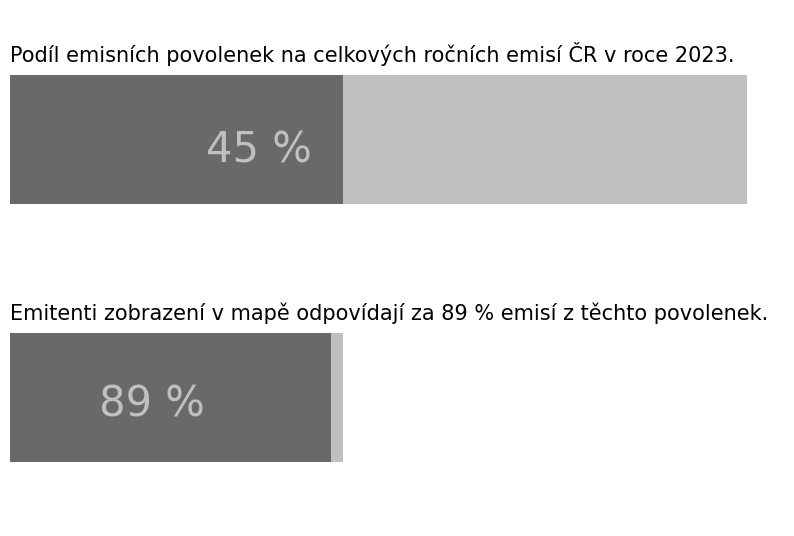

In [40]:
# Create df as a source for the charts.
data_charts = {
    "allowances": [part_2 - part_1, part_1],
    "other": [part_1 - (part_2 - part_1), 1.0 - part_1]
}
df_charts = pd.DataFrame(data_charts, index=["CR_2", "CR_rel"])

# Draw charts
draw_barh_charts(df_charts)


In [52]:
timestamp = date.today().strftime("%Y-%m-%d")

accompanying_text = f"""---
layout:     infographic
title:      "Největší emitenti v ČR v roce {YEAR}"
slug:       "nejvetsi-emitenti-cr"
redirect_from: "/nejvetsi-emitenti-cr"
published:  2021-01-20
weight:     98
tags-scopes: [ cr ]
tags-topics: [ emise ]
caption:    "Téměř polovinu roční produkce skleníkových plynů vypustí několik desítek producentů – elektráren, železáren, cementáren a rafinerií. Většina z nich se nachází v Ústeckém nebo Moravskoslezském kraji. Data jsou k roku {YEAR}."
dataset:    "emise-cr"
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on {timestamp}. Do not change here, fix it in the source notebook."
---

{{% include preview-box.html
    title="Emise skleníkových plynů v ČR podle sektorů"
    text="Velké podniky v Česku vypouštějí jen asi polovinu emisí skleníkových plynů. Celkový přehled o emisích v Česku nabízí jejich rozdělení podle sektorů."
    slug="emise-cr"
%}}

## Co vidíme v mapě?

* Mapa zobrazuje 30 největších zdrojů emisí skleníkových plynů v České republice – elektrárny a teplárny, ocelárny, cementárny a rafinerie. Zobrazení emitenti představují {100 * part_2:.0f} % emisí pokrytých emisními povolenkami ze systému <glossary id="euets">EU ETS</glossary> pro Českou republiku a celkově {100 * part_3:.0f} % ročních emisí skleníkových plynů České republiky.
* U každého zdroje je znázorněno množství emisí, jeden čtvereček odpovídá 250 000 t <glossary id="co2eq">CO<sub>2</sub>eq</glossary>. Barvy odlišují jednotlivá zařízení podle typu hlavní aktivity: elektrárny a teplárny, vápenky a cementárny, rafinérie, železárny a ocelárny. V oblasti Západních Čech je nakumulována většina zařízení určených k výrobě elektřiny a tepla, zatímco v Moravskoslezském kraji jsou hlavními emitenty podniky určené k výrobě železa a oceli. Významným zdrojem emisí CO<sub>2</sub> jsou také cementárny, jejichž celkový příspěvek v roce {YEAR} činil {czech_float(lime_cement_mtco2eq.round(1))} Mt CO<sub>2</sub>eq.
* Pro přehlednost jsme u některých zdrojů sloučili více různých emitentů registrovaných v systému ETS do jednoho zobrazeného celku. Např. _Plzeňská teplárenská_ má zvlášť registrované dvě velké teplárny v různých částech města nebo mnohé elektrárny mají zvlášť registrované svoje jednotlivé bloky. Dále jsme přiřadili k hutním podnikům jejich teplárenské složky, protože jsou nutnou součástí jejich provozu (to je jisté zjednodušení, protože tyto teplárenské podniky část vyrobeného tepla či páry dodávají i externím zákazníkům).
* Prakticky všechny zobrazené zdroje emisí produkují pouze CO<sub>2</sub>, jen rafinerie mohou vedle CO<sub>2</sub> vytvářet další skleníkové plyny. V rámci systému obchodování s emisními povolenkami EU ETS i v naší grafice jsou jiné skleníkové plyny než oxid uhličitý převedeny na ekvivalentní množství CO<sub>2</sub>, označované <glossary id="co2eq">CO<sub>2</sub>eq</glossary>.
* Nejvíce ze zobrazených zařízení vlastní _ČEZ_, další jsou ve vlastnictví _Sev.en Energy_, _Heidelberg Materials_ a dalších firem.

## Další poznámky

* Evropský ETS byl spuštěn v roce 2005 jako první mezinárodní systém pro obchodování s emisními povolenkami a pokrývá přibližně 40 % emisí skleníkových plynů v EU, především v sektorech energetiky, těžkého průmyslu a letectví. Data z EU ETS poskytují souhrnné údaje o emisích a povolenkách podle zemí, odvětví a roku a pocházejí hlavně z protokolu transakcí EU EUTL. Data jsou poskytována Evropskou komisí a spravována Evropskou agenturou pro životní prostředí.
* Pro širší kontext si můžete prohlédnout uhelné elektrárny světa na [interaktivní mapě](https://www.carbonbrief.org/mapped-worlds-coal-power-plants), která mj. umožňuje i posun v čase. Odpoví na otázky typu kdy nastal uhelný boom v Číně nebo jak výkonné máme elektrárny třeba oproti Polsku.
"""

print(accompanying_text)

---
layout:     infographic
title:      "Největší emitenti v ČR v roce 2023"
slug:       "nejvetsi-emitenti-cr"
redirect_from: "/nejvetsi-emitenti-cr"
published:  2021-01-20
weight:     98
tags-scopes: [ cr ]
tags-topics: [ emise ]
caption:    "Téměř polovinu roční produkce skleníkových plynů vypustí několik desítek producentů – elektráren, železáren, cementáren a rafinerií. Většina z nich se nachází v Ústeckém nebo Moravskoslezském kraji. Data jsou k roku 2023."
dataset:    "emise-cr"
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on 2025-09-26. Do not change here, fix it in the source notebook."
---

{% include preview-box.html
    title="Emise skleníkových plynů v ČR podle sektorů"
    text="Velké podniky v Česku vypouštějí jen asi polovinu emisí skleníkových plynů. Celkový přehled o emisích v Česku nabízí jejich rozdělení podle sektorů."
    slug="emise-cr"
%}

## Co vidíme v mapě?

* Mapa zobrazuje 30 největších zdrojů emisí skleníkových plynů 